# Data Preprocessing

Importing Requires Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
conn = sqlite3.connect('database.sqlite')

pd.read_sql_query("select * from Reviews",conn).head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


We not considering Neutral Reviews. Which are score=3.

In [3]:
data = pd.read_sql_query("select * from Reviews where Score != 3", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.isnull().values.any() # checking for empty values

False

Deduplication -> Dropping duplicates, if columns values 'productID', 'userid', 'Score', 'text' of a row matches with another.

In [5]:
# dropping duplicates
data = data.drop_duplicates(subset={"ProductId", "UserId", "Score", "Text"},keep='first', inplace=False)

Labeling sentiment of user by using his or her score. if score > 3 - positive and of score < 3 - negative.

In [6]:
tem = []

for row in data['Score']:
    if row > 3:
        tem.append("Positive")
    else:
        tem.append("Negative")

data['Sentiment'] = pd.Series(tem)
        
data = data.drop(['Score'], axis=1)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive


In [7]:
data['Sentiment'].value_counts()

Positive    441865
Negative     81540
Name: Sentiment, dtype: int64

=> Data Not well Balanced.

## Text Preprocessing

In [8]:
data = data[0:30000] # using only 30000 rows because my laptop taking long time to process below step.
data_x = data['Text']
data_y = data['Sentiment']

In [9]:
te = []
snow = nltk.stem.SnowballStemmer('english')
i = 0
N = len(data_x)
for sen in data_x:
    sen = sen.lower()
    cleanr = re.compile('<.*?>') # for cleaning html tags
    sen = re.sub(cleanr, ' ', sen)
    sen = re.sub(r'[?|!|\'|"|#]',r'',sen)
    sen = re.sub(r'[.|,|)|(|\|/]',r' ',sen)
    
    words = [snow.stem(word) for word in sen.split() if word not in stopwords.words('english')]
    te.append(words)
    print(f"{i/N*100:.1f} %", end="\r")
    i = i + 1

data_x = te    
print(data_x[0])

['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


In [10]:
te = []
for row in data_x:
    sen = ''
    for word in row:
        sen = sen + ' ' + word
    te.append(sen)
    
data_x = te
print(data_x[0])

 bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better


# Bag of Words

In [12]:
max_features = 5000 # we considering most frequent 5000 words
bow = CountVectorizer(max_features=max_features)
bow_data = bow.fit_transform(data_x)
print(bow_data[0])

  (0, 303)	1
  (0, 1727)	1
  (0, 2503)	1
  (0, 504)	2
  (0, 4019)	1
  (0, 2757)	1
  (0, 3444)	1
  (0, 4197)	1
  (0, 2587)	1
  (0, 2630)	1
  (0, 3518)	1
  (0, 1975)	1
  (0, 1818)	1
  (0, 3447)	3
  (0, 1789)	1
  (0, 1388)	1
  (0, 729)	1
  (0, 4765)	1
  (0, 3892)	1
  (0, 588)	1


## Dimensionality Reduction

In [15]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=1000)
tsvd_uni_vec = tsvd_uni.fit_transform(bow_data)

with default perplexity - 30 and number of iteration - 1000

In [18]:
from sklearn.manifold import TSNE
import random

n_samples = 10000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = data_y[sample_cols]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sample_features)

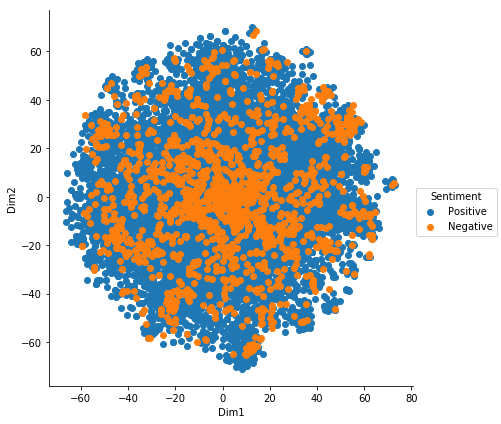

In [19]:
sample_class = np.array(sample_class).reshape(10000, 1)
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

with perplexity - 50 and number of iteration - 2500

In [36]:
model = TSNE(n_components=2, perplexity=50, n_iter=2500, random_state=0)
tsne_data = model.fit_transform(sample_features)

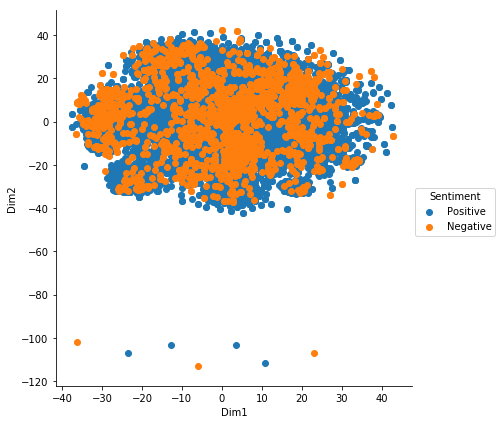

In [37]:
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# Using Tf-Idf

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(max_features=max_features)
tf_idf_data = tf_idf.fit_transform(data_x)
print(tf_idf_data[0])

  (0, 588)	0.148483110161
  (0, 3892)	0.181804751733
  (0, 4765)	0.353093662742
  (0, 729)	0.189447373812
  (0, 1388)	0.136980686916
  (0, 1789)	0.12918040285
  (0, 3447)	0.320013899062
  (0, 1818)	0.147449267689
  (0, 1975)	0.0975377287086
  (0, 3518)	0.169670396366
  (0, 2630)	0.14361202506
  (0, 2587)	0.08987616677
  (0, 4197)	0.303854801965
  (0, 3444)	0.224153776637
  (0, 2757)	0.209003245522
  (0, 4019)	0.176948150831
  (0, 504)	0.274735319889
  (0, 2503)	0.348868827267
  (0, 1727)	0.284274788208
  (0, 303)	0.249323739514


## Dimensionality Reduction

In [44]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=1000)
tsvd_uni_vec = tsvd_uni.fit_transform(tf_idf_data)

with default perplexity - 30 and number of iteration - 1000

In [45]:
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]

sample_class = data_y[sample_cols]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sample_features)

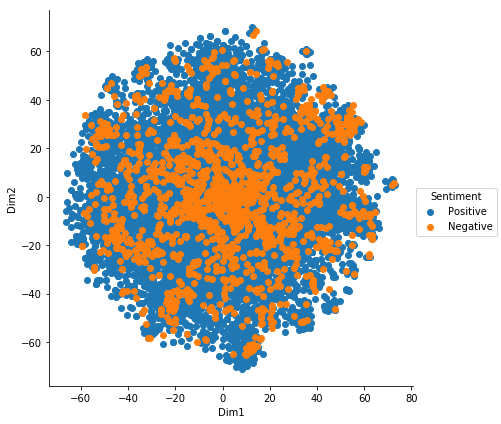

In [46]:
sample_class = np.array(sample_class).reshape(10000, 1)
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# Bi-gram BoW

In [47]:
max_features = 5000 # we considering most frequent 5000 bi-grams
bow = CountVectorizer(ngram_range=(1,2) ,max_features=max_features)
bow_data = bow.fit_transform(data_x)
print(bow_data[0])

  (0, 2640)	1
  (0, 3434)	1
  (0, 3513)	1
  (0, 1926)	1
  (0, 1705)	1
  (0, 1228)	1
  (0, 261)	1
  (0, 1588)	1
  (0, 427)	2
  (0, 3949)	1
  (0, 2818)	1
  (0, 3411)	1
  (0, 4098)	1
  (0, 2520)	1
  (0, 2634)	1
  (0, 3508)	1
  (0, 1896)	1
  (0, 1724)	1
  (0, 3413)	3
  (0, 1689)	1
  (0, 1221)	1
  (0, 640)	1
  (0, 3845)	1
  (0, 515)	1


## Dimensionality Reduction

In [48]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=1000)
tsvd_uni_vec = tsvd_uni.fit_transform(bow_data)

In [50]:
from sklearn.manifold import TSNE
import random

n_samples = 10000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]

sample_class = data_y[sample_cols]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sample_features)

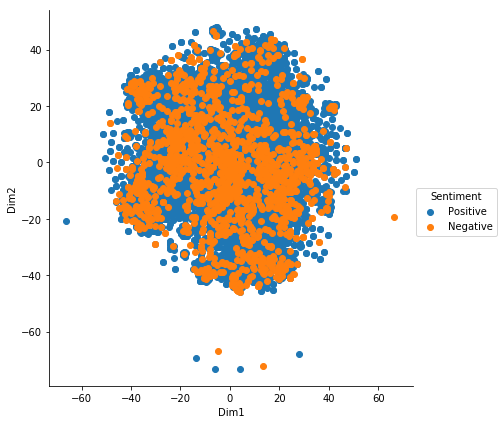

In [51]:
sample_class = np.array(sample_class).reshape(10000, 1)
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# Bi-gram Tf-idf

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
tf_idf_data = tf_idf.fit_transform(data_x)
print(tf_idf_data[0])

  (0, 515)	0.136684626135
  (0, 3845)	0.167358526457
  (0, 640)	0.174393864957
  (0, 1221)	0.126096186688
  (0, 1689)	0.11891571404
  (0, 3413)	0.294585559961
  (0, 1724)	0.135732932899
  (0, 1896)	0.0897873702147
  (0, 3508)	0.156188368283
  (0, 2634)	0.132200597985
  (0, 2520)	0.082734596818
  (0, 4098)	0.27971046647
  (0, 3411)	0.206342493252
  (0, 2818)	0.192395824982
  (0, 3949)	0.162887831589
  (0, 427)	0.252904821596
  (0, 1588)	0.261686282728
  (0, 261)	0.229512448152
  (0, 1228)	0.197652108135
  (0, 1705)	0.270659010549
  (0, 1926)	0.238535219592
  (0, 3513)	0.254401685043
  (0, 3434)	0.289023881486
  (0, 2640)	0.209557461981


## Dimensional Reduction

In [53]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=1000)
tsvd_uni_vec = tsvd_uni.fit_transform(tf_idf_data)

In [54]:
from sklearn.manifold import TSNE
import random

n_samples = 10000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = data_y[sample_cols]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sample_features)

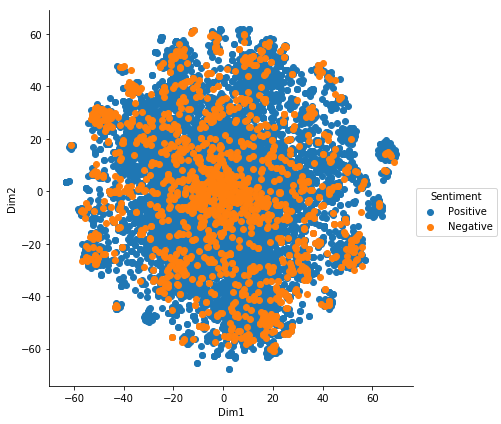

In [55]:
sample_class = np.array(sample_class).reshape(10000, 1)
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# Avg Word2vec

Training own word2vec using gensim

In [57]:
list_stn = []
for row in data_x:
    list_stn.append([word for word in row.split()])
    
print(list_stn[0])

['bought', 'sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti', 'product', 'look', 'like', 'stew', 'process', 'meat', 'smell', 'better', 'labrador', 'finicki', 'appreci', 'product', 'better']


In [58]:
w2v = Word2Vec(list_stn,min_count=5,size=150, workers=4)

In [67]:
data_avgw2v = []
for row in list_stn:
    te = [0 for i in range(150)]
    num = 0
    for word in row:
        try:
            te += w2v[word]
            num += 1
        except:
            pass
    data_avgw2v.append(te/num)
    
print(data_avgw2v[0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


[ 0.16649303  0.21208144  0.12497554  0.08821826  0.19200603 -0.30238699
  0.30269997  0.30756588 -0.30952322  0.23953508  0.04402963 -0.06058351
 -0.49042717 -0.44268839 -0.01969751 -0.1330498  -0.21721407  0.4750205
 -0.0786357  -0.39280639 -0.29441656  0.07430761 -0.03297411 -0.27513692
 -0.07418109 -0.43511003  0.45091685  0.23070594  0.14509956 -0.11644364
  0.29302409  0.15593768 -0.17087284  0.0919881  -0.01986258  0.17705594
 -0.02496266  0.0862422   0.16032143  0.20541799  0.32344697 -0.04961917
 -0.24654651  0.09760697  0.14460603  0.07399728  0.41002572  0.06357842
  0.41941165  0.0460577  -0.28140356 -0.44816645 -0.15793946  0.10839744
 -0.04367854  0.08871245 -0.0821688   0.43230672 -0.49723186 -0.03325426
  0.3987397   0.2693984  -0.31609773  0.20602536  0.11013477 -0.25410787
  0.11241874 -0.77293377 -0.18690388  0.27220668 -0.08516528  0.24699243
  0.11065397  0.00927052 -0.20798528 -0.5116099  -0.17351674  0.35871179
  0.00222569  0.30237257  0.0177251  -0.08149181 -0.

## Dimensionality Reduction

In [68]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=100)
tsvd_uni_vec = tsvd_uni.fit_transform(data_avgw2v)

In [69]:
from sklearn.manifold import TSNE
import random

n_samples = 10000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = data_y[sample_cols]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sample_features)

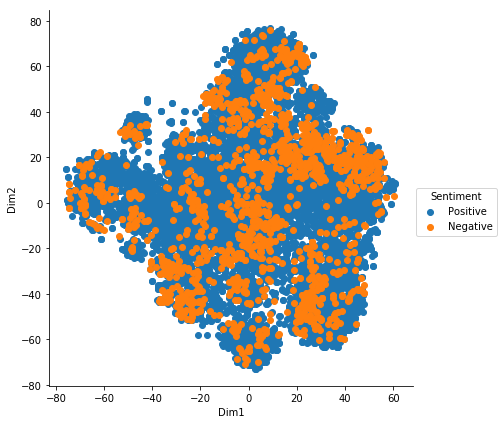

In [70]:
sample_class = np.array(sample_class).reshape(10000, 1)
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

# tf-idf word2vec

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(max_features=max_features)
tf_idf_data = tf_idf.fit_transform(data_x)
print(tf_idf_data[0])

  (0, 588)	0.148483110161
  (0, 3892)	0.181804751733
  (0, 4765)	0.353093662742
  (0, 729)	0.189447373812
  (0, 1388)	0.136980686916
  (0, 1789)	0.12918040285
  (0, 3447)	0.320013899062
  (0, 1818)	0.147449267689
  (0, 1975)	0.0975377287086
  (0, 3518)	0.169670396366
  (0, 2630)	0.14361202506
  (0, 2587)	0.08987616677
  (0, 4197)	0.303854801965
  (0, 3444)	0.224153776637
  (0, 2757)	0.209003245522
  (0, 4019)	0.176948150831
  (0, 504)	0.274735319889
  (0, 2503)	0.348868827267
  (0, 1727)	0.284274788208
  (0, 303)	0.249323739514


In [105]:
data_tfidfw2v = []
tf_idf_data = tf_idf_data.toarray()
i = 0
for row in list_stn:
    te = [0 for i in range(150)]
    
    temp_tfidf = []
    for val in tf_idf_data[i]:
        if val != 0:
            temp_tfidf.append(val)
    
    num = 0
    tf_idf_sum = 0
    for word in row:
        try:
            num += 1
            tf_idf_sum = tf_idf_sum + temp_tfidf[num-1]
            te += (temp_tfidf[num-1] * w2v[word])
        except:
            pass
    te = (float)(1/tf_idf_sum) * te
    data_tfidfw2v.append(te)
    i = i + 1
    
print(data_tfidfw2v[0])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[  2.47109818e-01   1.82069439e-01   4.59907247e-02   1.14924956e-01
   2.05242894e-01  -3.70539318e-01   3.85576473e-01   2.46950283e-01
  -2.30257665e-01   2.36382488e-01   2.78410695e-01   2.14923023e-02
  -3.98121735e-01  -3.81364717e-01  -7.98161620e-02  -1.55033426e-01
  -2.33083897e-01   4.68611211e-01  -1.20376931e-01  -3.49519925e-01
  -3.51989826e-01   1.70246878e-01   2.00478730e-02  -2.59652538e-01
  -3.74013813e-02  -3.69597188e-01   5.25810297e-01   1.06773090e-01
   1.19408915e-01  -1.21845384e-01   2.35883740e-01   1.35062186e-01
  -1.97178443e-01   1.01877427e-01  -7.22025575e-03   2.44807043e-01
  -5.76411493e-02   6.14237323e-02   2.22396702e-01   2.32497056e-01
   3.92899188e-01  -2.36371061e-02  -2.54081858e-01   7.42452592e-02
   1.67296792e-01   1.99980495e-01   3.35300108e-01   1.35078253e-02
   3.41573035e-01   3.87267787e-02  -3.21643676e-01  -4.65586985e-01
  -2.52646980e-01   8.87311261e-02  -1.59944336e-01   2.12969460e-02
  -2.96685913e-02   2.95641645e-01

## Dimensional reduction

In [106]:
from sklearn.decomposition import TruncatedSVD

tsvd_uni = TruncatedSVD(n_components=100)
tsvd_uni_vec = tsvd_uni.fit_transform(data_tfidfw2v)

In [107]:
from sklearn.manifold import TSNE
import random

n_samples = 10000
sample_cols = random.sample(range(1, tsvd_uni_vec.shape[0]), n_samples)
sample_features = tsvd_uni_vec[sample_cols]
# sample_features = df
sample_class = data_y[sample_cols]

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(sample_features)

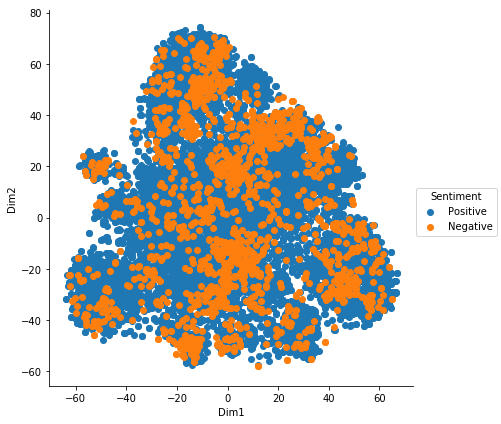

In [108]:
sample_class = np.array(sample_class).reshape(10000, 1)
finale_data = np.concatenate((tsne_data, sample_class), axis=1)
finale_data = pd.DataFrame(finale_data, columns=["Dim1", "Dim2", "Sentiment"])

sns.FacetGrid(finale_data,hue="Sentiment",size=6).map(plt.scatter,"Dim1","Dim2").add_legend()
plt.show()

## Summary

* Reduced 5000 dimensional data of Bag of words and tf-idf data to 2 - dimensional data using truncated svd and t-sne.


* Reduced 150 dimensional data of avg-word2vec and tf-idf-word2vec to 2 - dimensional data using truncated svd and t-sne.


* Successfully plotted their respective plots using Facetgrid function from Seaborn library.

Finally we can observe that no plot is easily separable.